# In-Depth: Manifold Learning

# 深入：流形學習

> We have seen how principal component analysis (PCA) can be used in the dimensionality reduction task—reducing the number of features of a dataset while maintaining the essential relationships between the points.
While PCA is flexible, fast, and easily interpretable, it does not perform so well when there are *nonlinear* relationships within the data; we will see some examples of these below. To address this deficiency, we can turn to a class of methods known as *manifold learning*—a class of unsupervised estimators that seeks to describe datasets as low-dimensional manifolds embedded in high-dimensional spaces.When you think of a manifold, I'd suggest imagining a sheet of paper: this is a two-dimensional object that lives in our familiar three-dimensional world, and can be bent or rolled in that two dimensions.In the parlance of manifold learning, we can think of this sheet as a two-dimensional manifold embedded in three-dimensional space.

上一節介紹了主成分分析（PCA）用來進行降維，即減少數據集特徵的數量卻保留了數據點之間的關聯。雖然PCA很靈活快速和容易解釋，但它在*非線性*關係的時候表現不是特別好；我們會在下面的一些例子中看到。要解決上面的問題，我們可以使用一類被稱為*流形學習(manifold learning)*的方法，這是一類無監督學習評估器試圖使用低維度的流形來描述高緯度空間的數據集。當提到流形時，我們可以想像一張紙：這是一個二維的對象，處於我們熟悉的三維世界中，還能在這個基礎上被彎曲或翻捲。如果類推到流形學習中，我們可以將這張紙看成是三維空間中的二維流形。

## Manifold Learning: "HELLO"

## 流形學習的“HELLO”

> To make these concepts more clear, let's start by generating some two-dimensional data that we can use to define a manifold.Here is a function that will create data in the shape of the word "HELLO": Let's call the function and visualize the resulting data:

為令這些概念更加清晰，讓我們首先創建一些二維數據可以用來定義流形。下面是創建一個“HELLO”形狀的數據的函數定義：調用函數展示結果圖像：

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

def make_hello(N=1000, rseed=42):
    fig, ax = plt.subplots(figsize=(4, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.text(0.5, 0.4, 'HELLO', va='center', ha='center', weight='bold', size=85)
    fig.savefig('hello.png')
    plt.close(fig)
    
    # 在HELLO字體附近隨機繪製一些圖像點
    from matplotlib.image import imread
    data = imread('hello.png')[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    return X[np.argsort(X[:, 0])]

> The output is two dimensional, and consists of points drawn in the shape of the word, "HELLO".
This data form will help us to see visually what these algorithms are doing.

輸出結果是二維的，包括著沿著HELLO形狀繪製的點。這個數據會幫助我們可視化的展示算法的行為。

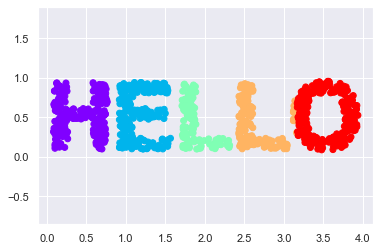

In [2]:
X = make_hello(1000)
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5))
plt.scatter(X[:, 0], X[:, 1], **colorize)
plt.axis('equal');

> Rotating, re-orienting, or stretching the piece of paper in three-dimensional space doesn't change the flat geometry of the paper: such operations are akin to linear embeddings.If you bend, curl, or crumple the paper, it is still a two-dimensional manifold, but the embedding into the three-dimensional space is no longer linear.Manifold learning algorithms would seek to learn about the fundamental two-dimensional nature of the paper, even as it is contorted to fill the three-dimensional space.Here we will demonstrate a number of manifold methods, going most deeply into a couple techniques: multidimensional scaling (MDS), locally linear embedding (LLE), and isometric mapping (IsoMap).

在三維空間中旋轉、重定位或者延展這張紙不會改變紙張的平面幾何特性：這樣的操作都可以歸類為線性嵌入操作。如果你彎曲、捲曲或者翻捲紙張，它仍然是一個二維流形，但是這些操作在三維空間中不再是線性嵌入操作。流形學習算法會試圖找到這張紙的二維本質，即使它捲曲延伸在一個三維空間中。本節中我們會展示一些流形學習方法，底層主要依賴三個技巧：
- 多維縮放（MDS）
- 本地線性嵌入（LLE）
- 等距映射（IsoMap）。

## Multidimensional Scaling (MDS)

## (1)多維縮放（MDS）

> Looking at data like this, we can see that the particular choice of *x* and *y* values of the dataset are not the most fundamental description of the data: we can scale, shrink, or rotate the data, and the "HELLO" will still be apparent.
For example, if we use a rotation matrix to rotate the data, the *x* and *y* values change, but the data is still fundamentally the same:

看到這樣的數據，我們可以想像，圖中這些特殊選擇的*x*和*y*值並不是數據最基礎的描述：我們可以縮放或者旋轉數據，這個HELLO形狀仍然會很明顯。例如，如果我們如下旋轉數據集：

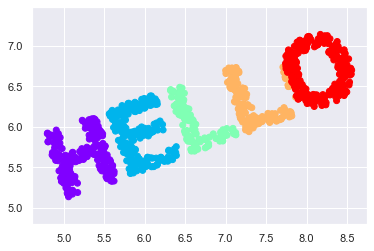

In [3]:
def rotate(X, angle):
    theta = np.deg2rad(angle)
    R = [[np.cos(theta), np.sin(theta)],
         [-np.sin(theta), np.cos(theta)]]
    return np.dot(X, R)
    
X2 = rotate(X, 20) + 5
plt.scatter(X2[:, 0], X2[:, 1], **colorize)
plt.axis('equal');

> This tells us that the *x* and *y* values are not necessarily fundamental to the relationships in the data.
What *is* fundamental, in this case, is the *distance* between each point and the other points in the dataset.
A common way to represent this is to use a distance matrix: for $N$ points, we construct an $N \times N$ array such that entry $(i, j)$ contains the distance between point $i$ and point $j$.
Let's use Scikit-Learn's efficient ``pairwise_distances`` function to do this for our original data. for our *N*=1,000 points, we obtain a 1000×1000 matrix, which can be visualized as shown here

上面的例子告訴我們數據集中的*x*和*y*值並不是數據關係中必不可少的基礎成分。在這個情況下，最基礎的是數據集每個點和其他點之間*距離*。使用距離矩陣來表示是一種通用的方法：對於$N$個點，我們構建一個$N \times N$數組，數組中的元素$(i, j)$指代的是點$i$和點$j$之間的距離。下面我們使用Scikit-Learn中高效的`pairwise_distance`函數來為我們的原始數據創建距離矩陣：對於我們*N*=1000個點，我們獲得了一個1000×1000的矩陣，我們可以如下可視化這個矩陣：

In [4]:
from sklearn.metrics import pairwise_distances
D = pairwise_distances(X)
D.shape

(1000, 1000)

> 



/var/folders/9q/486czkcn7lv5v0hwbt71twdc0000gn/T/ipykernel_1475/321991705.py:2: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar();


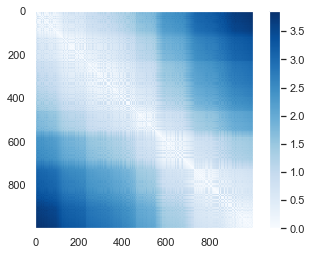

In [5]:
plt.imshow(D, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();

> If we similarly construct a distance matrix for our rotated and translated data, we see that it is the same:

如果我們採用同s樣的方法對旋轉投射後的數據構建一個距離矩陣，我們就可以發現它們是相同的：

In [6]:
D2 = pairwise_distances(X2)
np.allclose(D, D2)

True

> This distance matrix gives us a representation of our data that is invariant to rotations and translations, but the visualization of the matrix above is not entirely intuitive.
In the representation shown in this figure, we have lost any visible sign of the interesting structure in the data: the "HELLO" that we saw before.

雖然這個距離矩陣為我們提供了數據對於旋轉和投射不敏感的證據，但是對矩陣的可視化結果卻是完全不直觀的。在距離矩陣的可視化圖中，我們損失了任何數據關鍵結構中的可視標誌：也就是前面我們能看到的“HELLO”。

> Further, while computing this distance matrix from the (x, y) coordinates is straightforward, transforming the distances back into *x* and *y* coordinates is rather difficult.
This is exactly what the multidimensional scaling algorithm aims to do: given a distance matrix between points, it recovers a $D$-dimensional coordinate representation of the data.
Let's see how it works for our distance matrix, using the ``precomputed`` dissimilarity to specify that we are passing a distance matrix:

還有就是雖然從(x, y)坐標中計算得到距離矩陣是很直接的，但是將距離矩陣轉換回(x, y)坐標卻是非常困難的。這正是多維縮放算法的目標：給定點之間的距離矩陣，將其還原成一個$D$維坐標的數據表示。在我們的距離矩陣上使用`precomputed`不相似度來指定我們傳遞的是距離矩陣：

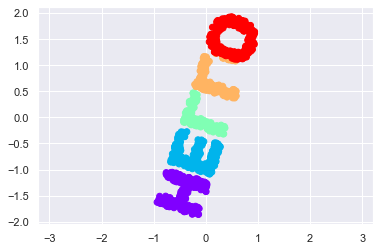

In [7]:
from sklearn.manifold import MDS
model = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
out = model.fit_transform(D)
plt.scatter(out[:, 0], out[:, 1], **colorize)
plt.axis('equal');

> The MDS algorithm recovers one of the possible two-dimensional coordinate representations of our data, using *only* the $N\times N$ distance matrix describing the relationship between the data points.

MDS算法還原了我們數據的一種可能的二維坐標表示，其中僅僅使用了描述數據點之間關係的$N \times N$的距離矩陣。

### MDS as Manifold Learning MDS進行流形學習

> The usefulness of this becomes more apparent when we consider the fact that distance matrices can be computed from data in *any* dimension.
So, for example, instead of simply rotating the data in the two-dimensional plane, we can project it into three dimensions using the following function (essentially a three-dimensional generalization of the rotation matrix used earlier):

當我們考慮到距離矩陣可以從*任何*維度的數據中計算得到時，上述特性變得更加明顯。例如，我們可以將“HELLO”投射到3維中而不是上面的二維旋轉，使用下面的函數（基本上就是前面的矩陣旋轉函數的三維通用版本）即可實現：

In [8]:
def random_projection(X, dimension=3, rseed=42):
    assert dimension >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C = rng.randn(dimension, dimension)
    e, V = np.linalg.eigh(np.dot(C, C.T))
    return np.dot(X, V[:X.shape[1]])
    
X3 = random_projection(X, 3)
#X3.shape

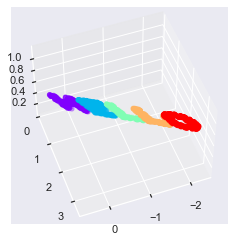

In [9]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(X3[:, 0], X3[:, 1], X3[:, 2],
             **colorize)
ax.view_init(azim=70, elev=50)

> We can now ask the ``MDS`` estimator to input this three-dimensional data, compute the distance matrix, and then determine the optimal two-dimensional embedding for this distance matrix.
The result recovers a representation of the original data:

我們可以將這個三維數據作為輸入代入`MDS`評估器，計算距離矩陣，然後求出該距離矩陣最優化的二維表示。結果還原了原始數據的最基礎特徵：

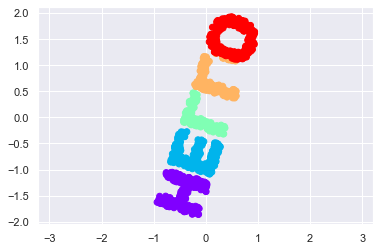

In [10]:
model = MDS(n_components=2, random_state=1)
out3 = model.fit_transform(X3)
plt.scatter(out3[:, 0], out3[:, 1], **colorize)
plt.axis('equal');

> This is essentially the goal of a manifold learning estimator: given high-dimensional embedded data, it seeks a low-dimensional representation of the data that preserves certain relationships within the data.
In the case of MDS, the quantity preserved is the distance between every pair of points.

這就是流形學習評估器的最基本目標：給定高維度的數據，它能找到一個低維度的數據表示，並且保留大部分數據之間的聯繫。在MDS算法中，被保留下來的數量是每兩個點之間的距離。

### Nonlinear Embeddings: Where MDS Fails  非線性嵌入：MDS會失效

> Our discussion thus far has considered *linear* embeddings, which essentially consist of rotations, translations, and scalings of data into higher-dimensional spaces.
Where MDS breaks down is when the embedding is nonlinear—that is, when it goes beyond this simple set of operations.
Consider the following embedding, which takes the input and contorts it into an "S" shape in three dimensions:

目前為止我們討論的都是*線性*嵌入，基本上就是包括將數據旋轉、轉換和縮放到高維空間。 MDS會在非線性嵌入的情況下失效：這種情況下超越了上述簡單的操作。考慮下面這種嵌入，函數會將輸入扭曲成一個三維空間中的“S”形狀：

In [11]:
def make_hello_s_curve(X):
    t = (X[:, 0] - 2) * 0.75 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T

XS = make_hello_s_curve(X)

>This is again three-dimensional data, but we can see that the embedding is much more complicated:

結果還是三維數據，但是我們可以看到這個嵌入比前面複雜多了：

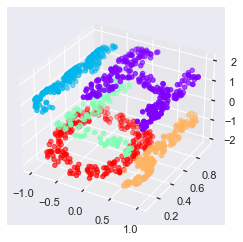

In [12]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2],
             **colorize);

> The fundamental relationships between the data points are still there, but this time the data has been transformed in a nonlinear way: it has been wrapped-up into the shape of an "S."If we try a simple MDS algorithm on this data, it is not able to "unwrap" this nonlinear embedding, and we lose track of the fundamental relationships in the embedded manifold:

數據點之間的基本關係仍然保留下來了，但是這次數據被轉換成了非線性形狀：它們被封裝成了一個“S”的形狀。如果我們在這之上嘗試簡單的MDS算法，它將無法對這種非線性嵌入進行解封裝，也就是我們失去了這個嵌入流形的基礎關係：

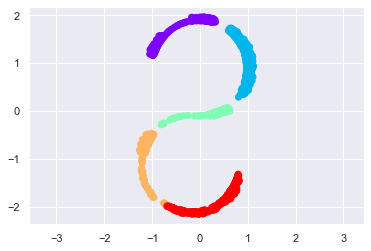

In [13]:
from sklearn.manifold import MDS
model = MDS(n_components=2, random_state=2)
outS = model.fit_transform(XS)
plt.scatter(outS[:, 0], outS[:, 1], **colorize)
plt.axis('equal');

> The best two-dimensional *linear* embeding does not unwrap the S-curve, but instead throws out the original y-axis.

二維最好的“線性”嵌入無法將S曲線解封裝，而是直接返回了原始數據的y軸。

## Nonlinear Manifolds: Locally Linear Embedding (LLE)

## (2) 非線性流形：本地線性嵌入 (LLE)

> How can we move forward here? Stepping back, we can see that the source of the problem is that MDS tries to preserve distances between faraway points when constructing the embedding.
But what if we instead modified the algorithm such that it only preserves distances between nearby points?
The resulting embedding would be closer to what we want.

我們該如何進行下去呢？回想一下，我們發現問題的根源在於MDS保留了相隔很遠的點之間的距離。如果我們修改一下算法，讓它僅僅保留附近的點之間的距離呢？結果的嵌入方式會更加接近我們希望得到的。

![(LLE vs MDS linkages)](figures/05.10-LLE-vs-MDS.png)
[附录中生成图像的代码](06.00-Figure-Code.ipynb#LLE-vs-MDS-Linkages)

> Here each faint line represents a distance that should be preserved in the embedding.
On the left is a representation of the model used by MDS: it tries to preserve the distances between each pair of points in the dataset.
On the right is a representation of the model used by a manifold learning algorithm called locally linear embedding (LLE): rather than preserving *all* distances, it instead tries to preserve only the distances between *neighboring points*: in this case, the nearest 100 neighbors of each point.

上面每條淡色的線條代表著在嵌入算法中需要保留的距離。左圖表示的MDS算法：它保留了數據集中每一對點之間的距離。右圖展示的是被稱為本地線性嵌入（LLE）的一種流形學習算法：與其保留*所有*距離，它僅僅保留了那些*鄰近點*之間的距離：在這個例子中，每個點都有100個最鄰近的點。

> Thinking about the left panel, we can see why MDS fails: there is no way to flatten this data while adequately preserving the length of every line drawn between the two points.
For the right panel, on the other hand, things look a bit more optimistic. We could imagine unrolling the data in a way that keeps the lengths of the lines approximately the same.
This is precisely what LLE does, through a global optimization of a cost function reflecting this logic.

再次考慮左圖，我們可以發現MDS失效的原因：它無法將這些距離數據平鋪出來，因為每兩個點之間的距離都被保留了下來。對於右圖來說，情況樂觀得多，我們可以想像成沿著S形狀將數據展開出來，因為不沿著這個形狀的兩點之間的距離並沒有被保留下來。這就是LLE的原理，通過一個反映該邏輯的損失函數進行全局的優化。

> LLE comes in a number of flavors; here we will use the *modified LLE* algorithm to recover the embedded two-dimensional manifold.
In general, modified LLE does better than other flavors of the algorithm at recovering well-defined manifolds with very little distortion:

LLE有許多的方式；這裡我們採用了改良LLE（*modified LLE*）算法來還原嵌入的二維流形。在通常情況下，改良LLE在還原良好定義流形的實踐中要比其他算法的表現都要優異，造成的扭曲非常少：

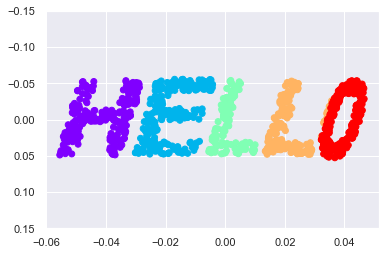

In [14]:
from sklearn.manifold import LocallyLinearEmbedding
model = LocallyLinearEmbedding(n_neighbors=100, n_components=2, method='modified',
                               eigen_solver='dense')
out = model.fit_transform(XS)

fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], **colorize)
ax.set_ylim(0.15, -0.15);

> The result remains somewhat distorted compared to our original manifold, but captures the essential relationships in the data!

結果和原始流形比較還是存在一些變形，但是它還是捕獲了數據中的關鍵關係。

## Some Thoughts on Manifold Methods

## 關於流形方法的思考

> Though this story and motivation is compelling, in practice manifold learning techniques tend to be finicky enough that they are rarely used for anything more than simple qualitative visualization of high-dimensional data.

雖然本節以及上面講述很吸引人，但是實踐中流形學習技巧卻是非常挑剔的，導致它們很少在除了將高維度數據進行數值可視化領域外使用。下面列出了一些流形學習的缺點，基本上都是與PCA比較的：

- 在流形學習中，沒有好的框架來處理缺失數據。相反在PCA中，有很多直接和有效的方法實現缺失數據處理。
- 在流形學習中，數據中的噪聲可能會導致流形“短路”從而劇烈的改變嵌入結果。相反，PCA可以在最重要成分之外很自然的過濾噪聲。
- 流形嵌入結果通常高度依賴於臨近點個數的選擇，並且沒有通用可證的數值方法來選擇鄰近點數量的最優解。相反，PCA不存在這樣的選擇。
- 在流形學習中，輸出維度的全局最優解很難得到。相反，PCA通過可解釋方差可以找到輸出維度的全局最優解。
- 在流形學習中，嵌入維度的含義並不總是清晰的。 PCA中的主成分有著非常明確的含義。
- 流形學習中流形算法的計算複雜度通常是O[N^2]或O[N^3]。而PCA存在隨機方法，通常計算快許多（當然你也可以參看[megaman](https://github.com/mmp2/megaman)包，這裡包含一些更具擴展性的流形學習的計算實現）。

> With all that on the table, the only clear advantage of manifold learning methods over PCA is their ability to preserve nonlinear relationships in the data; for that reason I tend to explore data with manifold methods only after first exploring them with PCA.

有了上表列出的這些缺點，流形學習對比PCA只有一個明顯的優點，就是它能保留數據中的非線性關係；因此，作者建議對數據完成了PCA分析之後，再採用流形學習方法。

> Scikit-Learn implements several common variants of manifold learning beyond Isomap and LLE: the Scikit-Learn documentation has a [nice discussion and comparison of them](http://scikit-learn.org/stable/modules/manifold.html).
Based on my own experience, I would give the following recommendations:

Scikit-Learn除了Isomap和LLE之外，還實現了一些常見的流形學習方法變體：Scikit-Learn文檔中有一篇[很好的針對它們的討論和比較文章](http://scikit-learn.org/stable/modules/manifold.html)。基於作者自身的經驗，給出了下面的一些建議：

- 對於一些玩具問題，例如我們前面看到的S曲線，本地線性嵌入（LLE）和它的變體（特別是改良LLE）表現的很優秀。它們實現在`sklearn.manifold.LocallyLinearEmbedding`。
- 對於真實世界中的高維度數據，LLE經常產生很差的結果，而等距映射（IsoMap）通常會得到更加有意義的嵌入。它們實現在`sklearn.manifold.Isomap`。
- 對於高度聚集的數據，T-分佈隨機近鄰嵌入（t-SNE）工作的較好，雖然相對其他方法來說它非常慢。它們實現在`sklearn.manifold.TSNE`。

## Example: Isomap on Faces (Isomap)

## (3) 例子：人臉數據上使用 Isomap 等距映射

> One place manifold learning is often used is in understanding the relationship between high-dimensional data points.
A common case of high-dimensional data is images: for example, a set of images with 1,000 pixels each can be thought of as a collection of points in 1,000 dimensions – the brightness of each pixel in each image defines the coordinate in that dimension.

流形學習經常被用來理解高維度數據點之間的關係。圖像是高維度數據的常見場景：例如，一組的1000像素點的圖像，其中的每一張都可以被認為是1000維數據點的集合，每個像素的亮度定義了該維度的坐標值。下面我們將Isomap算法應用到一些人臉數據上。使用下面的命令會下載數據並將其緩存在你的主目錄中：

In [15]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)
faces.data.shape

(1498, 2914)

> We have 2,370 images, each with 2,914 pixels.
In other words, the images can be thought of as data points in a 2,914-dimensional space!

我們有2370張圖像，每張都是2914個像素。換言之，每張圖像都可以被認為是在2914維空間中的數據點的集合。

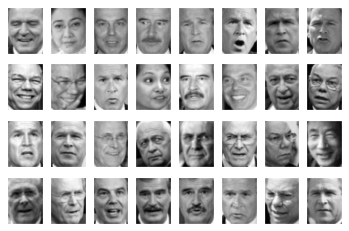

In [16]:
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

> We would like to plot a low-dimensional embedding of the 2,914-dimensional data to learn the fundamental relationships between the images.
One useful way to start is to compute a PCA, and examine the explained variance ratio, which will give us an idea of how many linear features are required to describe the data:

我們希望繪製這些2914維數據的低維度嵌入，從而獲得這些圖像之間的基本關係。從計算PCA開始是一個不錯的辦法，然後檢查可解釋方差的比率，能為我們提供描述數據所需的線性特徵值數量的基本概念：

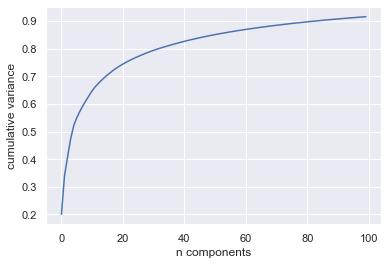

In [17]:
from sklearn.decomposition import PCA as RandomizedPCA
model = RandomizedPCA(100).fit(faces.data)
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('cumulative variance');

> We see that for this data, nearly 100 components are required to preserve 90% of the variance: this tells us that the data is intrinsically very high dimensional—it can't be described linearly with just a few components.

我們從上圖可見，接近100個成分就能保留90%的差異：這告訴我們，這些數據本質上是非常高維度的，它無法僅使用幾個成分進行線性描述。

> When this is the case, nonlinear manifold embeddings like LLE and Isomap can be helpful.
We can compute an Isomap embedding on these faces using the same pattern shown before:

這種情況下，非線性流形嵌入如LLE和Isomap比較有幫助。我們可以使用Isomap嵌入來計算這些人臉數據的二維投射：

In [18]:
from sklearn.manifold import Isomap
model = Isomap(n_components=2)
proj = model.fit_transform(faces.data)
proj.shape

(1498, 2)

> The output is a two-dimensional projection of all the input images.
To get a better idea of what the projection tells us, let's define a function that will output image thumbnails at the locations of the projections:

輸出結果是所有輸入圖像的二維投射。要獲得這個二維投射的意義，我們定義一個函數，它會將相應的縮略圖繪製在投射點的對應位置：

In [19]:
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # 如果两点距离太近，不显示
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

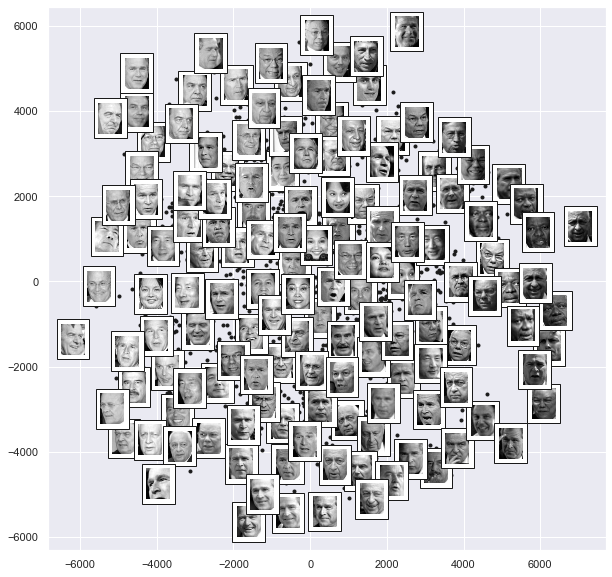

In [20]:
#result
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data,
                model=Isomap(n_components=2),
                images=faces.images[:, ::2, ::2])

> The result is interesting: the first two Isomap dimensions seem to describe global image features: the overall darkness or lightness of the image from left to right, and the general orientation of the face from bottom to top.
This gives us a nice visual indication of some of the fundamental features in our data.

這個結果很有趣：Isomap前兩個維度看起來是在描述圖像中的通用特徵：從左到右是圖像的亮度或暗度的變化，從上到下是圖像中人臉方向的變化。這能為我們提供關於數據關鍵特徵的很好的可視化指示。

> We could then go on to classify this data (perhaps using manifold features as inputs to the classification algorithm) as we did in [In-Depth: Support Vector Machines](05.07-Support-Vector-Machines.ipynb).

然後我們可以繼續對數據進行分類（使用流形特徵作為分類算法的輸入），正如我們在[深入：支持向量機](05.07-Support-Vector-Machines.ipynb)中做的那樣。

<!--NAVIGATION-->
< [深入：主成分分析](05.09-Principal-Component-Analysis.ipynb) | [目录](Index.ipynb) | [深入：k-均值聚类](05.11-K-Means.ipynb) >

<a href="https://colab.research.google.com/github/wangyingsm/Python-Data-Science-Handbook/blob/master/notebooks/05.10-Manifold-Learning.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>
